<a href="https://colab.research.google.com/github/omarja12/Thesis/blob/main/Master_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Master Thesis: Omar Jarir. 

In [154]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Defining the necessary functions.

In [155]:
# Function to create dataframe with metrics

def performanceMetricsDF(metricsObj, yTrain, yProbaPredTrain, yPredTrain, yTest, yProbaPredTest, yPredTest):
    measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC', 'AUC_Proba']
    train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain, average='weighted'),
                metricsObj.f1_score(yTrain, yPredTrain, average='weighted'),
                metricsObj.roc_auc_score(yTrain, yPredTrain),
                metricsObj.roc_auc_score(yTrain, yProbaPredTrain)     
                ]
    test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest),
               metricsObj.recall_score(yTest, yPredTest, average='weighted'),
               metricsObj.f1_score(yTest, yPredTest, average='weighted'),
               metricsObj.roc_auc_score(yTest, yPredTest),
               metricsObj.roc_auc_score(yTest, yProbaPredTest) 
               ]
    resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
    return(resultsDF)

In [156]:
# Function to find outliers on columns based on percentile
def removeOutliers(df, colList, lowPercentile=0.05, highPercentile=0.95, verbose=False):
    quant_df = df[colList].quantile([lowPercentile, highPercentile])
    if verbose:
        print(quant_df)
    for name in list(df[colList].columns):
        df = df[(df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name])]
    return df

## Importing the necassary libraries:

In [157]:
!pip install catboost

In [158]:
!pip install gplearn

In [159]:
!pip install category_encoders

In [160]:
!pip install scikit-plot

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import log_loss
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.neural_network import MLPClassifier
from sklearn.compose import make_column_transformer
from catboost import CatBoostClassifier
from scipy.stats import chi2
from matplotlib import patches
from sklearn.preprocessing import RobustScaler
from sklearn import preprocessing
from catboost import CatBoostClassifier
import catboost as ctb
from sklearn.metrics import roc_auc_score
from imblearn.ensemble import BalancedRandomForestClassifier
from gplearn.genetic import SymbolicClassifier
from sklearn.naive_bayes import GaussianNB


import numpy as np
from mlxtend.evaluate import mcnemar_table


# Loading packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import category_encoders as ce
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,mean_squared_error, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from yellowbrick.classifier import ClassificationReport

import scikitplot as skplt
import xgboost

## Reading the data:

In [162]:
import requests as rq
from io import BytesIO

url = "https://raw.githubusercontent.com/omarja12/Thesis/main/Train_Sample.csv"
data = rq.get(url).content
ds = pd.read_csv(BytesIO(data))

# Data Exploration:

In [163]:
ds.shape

(107702, 20)

The dataset contains only 18 variables, and 107702 observations.

In [164]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107702 entries, 0 to 107701
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      107702 non-null  int64  
 1   user_id         107702 non-null  object 
 2   REGION          64979 non-null   object 
 3   TENURE          107702 non-null  object 
 4   MONTANT         69841 non-null   float64
 5   FREQUENCE_RECH  69841 non-null   float64
 6   REVENUE         71367 non-null   float64
 7   ARPU_SEGMENT    71367 non-null   float64
 8   FREQUENCE       71367 non-null   float64
 9   DATA_VOLUME     54675 non-null   float64
 10  ON_NET          68236 non-null   float64
 11  ORANGE          62913 non-null   float64
 12  TIGO            42979 non-null   float64
 13  ZONE1           8391 non-null    float64
 14  ZONE2           6760 non-null    float64
 15  MRG             107702 non-null  object 
 16  REGULARITY      107702 non-null  int64  
 17  TOP_PACK  

We can notice that we do have some missing values in our dataset.

In [165]:
ds.head()

,Unnamed: 0,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,310599,24fd37ee41ce311df148625a1655bc3be7718128,NaN,K > 24 month,NaN,NaN,6.0,2.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NO,5,NaN,NaN,1
1,1680188,c7adc2f8be9ea9ed2f8d938fabc0854c8cadce90,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,6,NaN,NaN,1
2,1479542,afd73a49ac6a7e8d0fd0da21de20ca084822717e,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,4,NaN,NaN,0
3,2090839,f87b133123742497bf5dffdddeb933235e540f43,DAKAR,K > 24 month,9100.0,38.0,9300.0,3100.0,56.0,NaN,29.0,81.0,2.0,NaN,7.0,NO,57,On net 200F=Unlimited _call24H,7.0,0
4,1363869,a224adda8082435116848c10de088fe35f9155bd,DAKAR,K > 24 month,6500.0,13.0,6500.0,2167.0,13.0,NaN,112.0,65.0,18.0,NaN,NaN,NO,51,All-net 500F =2000F_AllNet_Unlimited,13.0,0


We need to get rid of some useless columns.

In [166]:
ds.drop(columns=['Unnamed: 0', 'user_id'], inplace=True)

In [167]:
# The dataset contains 4 categorical variables, the other 13 variables are numerical ones.
ds.dtypes

REGION             object
TENURE             object
MONTANT           float64
FREQUENCE_RECH    float64
REVENUE           float64
ARPU_SEGMENT      float64
FREQUENCE         float64
DATA_VOLUME       float64
ON_NET            float64
ORANGE            float64
TIGO              float64
ZONE1             float64
ZONE2             float64
MRG                object
REGULARITY          int64
TOP_PACK           object
FREQ_TOP_PACK     float64
CHURN               int64
dtype: object

## Exploring the categorical features:

In [168]:
ds.columns

Index(['REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE',
       'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO',
       'ZONE1', 'ZONE2', 'MRG', 'REGULARITY', 'TOP_PACK', 'FREQ_TOP_PACK',
       'CHURN'],
      dtype='object')

### The variable 'REGION':

<Figure size 864x720 with 0 Axes>

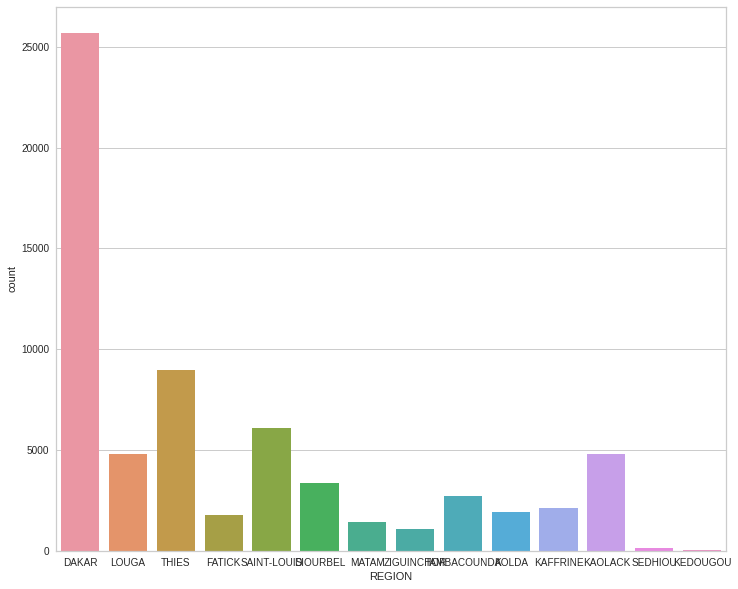

In [169]:
# Checking the count plot of the variable 'REGION'.

plt.figure(figsize=(12,10))
ax = sns.countplot(data=ds, x="REGION")

plt.show()

From the above plot we can see that most of the clients are located in the Daker region, followed by Thies region.

### The variable 'TENURE':

<Figure size 864x720 with 0 Axes>

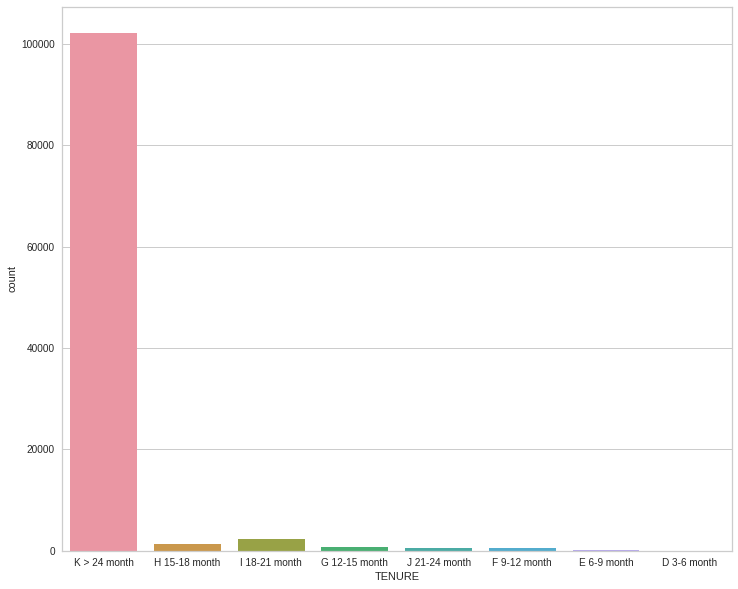

In [170]:
# Checking the count plot of the variable 'TENURE'.

plt.figure(figsize=(12,10))
ax = sns.countplot(data=ds, x="TENURE")

plt.show()

The plot above shows that the majority of tenures are superior than 24 months.

### The variable 'MRG':

<Figure size 432x288 with 0 Axes>

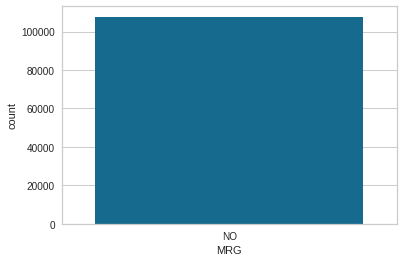

In [171]:
# Checking the count plot of the variable 'MRG'.

plt.figure(figsize=(6,4))
ax = sns.countplot(data=ds, x="MRG")

plt.show()

The plot above shows that the variable 'MRG' has a variance equal to zero, and thus should be dropped.

In [172]:
# Dropping the variable "MRG".
ds.drop(columns=["MRG"], inplace=True)

### The variable 'TOP_PACK':

In [173]:
# Contains too many categories, its not a good idea to plot a bar plot.
len(ds["TOP_PACK"].unique())

94

The variable 'TOP_PACK' contains too many categories and thus it is not a good idea to plot a bar plot.

### The target variable 'CHURN':

<Figure size 432x288 with 0 Axes>

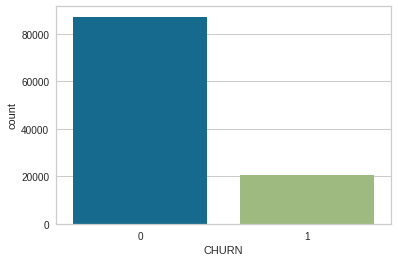

In [174]:
# Checking the count plot of the variable 'CHURN'.

plt.figure(figsize=(6,4))
ax = sns.countplot(data=ds, x="CHURN")

plt.show()

From the above plot we can clearly notice the class imbalance between churners customers and non churners. 

As expected the dataset contains much more loyal customers than churners.

## Exploring the numerical variables:

In [175]:
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
MONTANT,69841.0,5516.540485,7100.499514,37.0,1000.0,3000.0,7350.0,235500.0
FREQUENCE_RECH,69841.0,11.502040,13.228343,1.0,2.0,7.0,16.0,109.0
REVENUE,71367.0,5497.156375,7262.287468,1.0,1000.0,3000.0,7351.5,397968.0
ARPU_SEGMENT,71367.0,1832.392632,2420.757473,0.0,333.0,1000.0,2450.5,132656.0
FREQUENCE,71367.0,13.939216,14.661931,1.0,3.0,9.0,20.0,91.0
DATA_VOLUME,54675.0,3342.096790,12327.475303,0.0,0.0,258.0,2844.0,936054.0
ON_NET,68236.0,282.231168,886.697511,0.0,5.0,27.0,159.0,23595.0
ORANGE,62913.0,95.002654,202.957354,0.0,7.0,29.0,99.0,5429.0
TIGO,42979.0,22.793201,62.707106,0.0,2.0,6.0,21.0,2568.0
ZONE1,8391.0,8.032535,37.632040,0.0,0.0,1.0,3.0,1366.0


### The variable 'MONTANT':

#### Plotting the histograms for the numerical variables.  

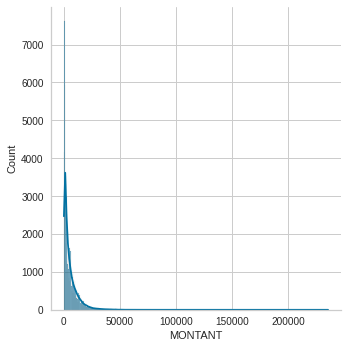

In [176]:
# Checking the histogram of the variable 'MONTANT'.

sns.displot(data=ds, x="MONTANT", kde=True)
plt.show()

In [177]:
# Calculating the skewness of the 'MONTANT' variable.
ds['MONTANT'].skew()

4.210039951875887

As we can we the distribution of the variable 'MONTANT' is right skewed with the presence of outliers.

### The variable 'FREQUENCE_RECH':

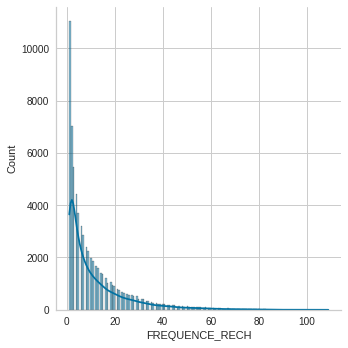

In [178]:
# Checking the histogram of the variable 'MONTANT'.

sns.displot(data=ds, x="FREQUENCE_RECH", kde=True)
plt.show()

In [179]:
# Calculating the skewness of the 'FREQUENCE_RECH' variable.
ds['FREQUENCE_RECH'].skew()

2.109445956996841

The plot above show that the distribution of the variable 'FREQUENCE_RECH' is right skewed.

### The variable 'REVENUE':

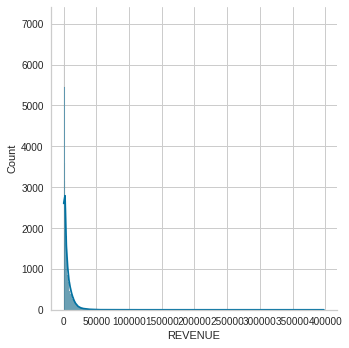

In [180]:
# Checking the histogram of the variable 'REVENUE'.

sns.displot(data=ds, x="REVENUE", kde=True)
plt.show()

In [181]:
# Calculating the skewness of the 'REVENUE' variable.
ds['REVENUE'].skew()

5.700184302345129

From the above plot we can see that the distribution of our variable is right skewed.

### The variable 'ARPU_SEGMENT':

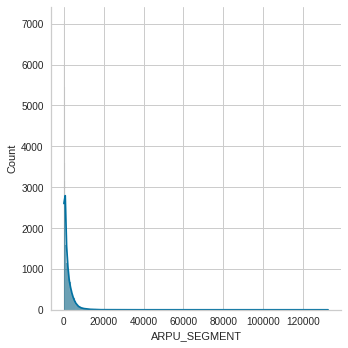

In [182]:
# Checking the histogram of the variable 'ARPU_SEGMENT'.

sns.displot(data=ds, x="ARPU_SEGMENT", kde=True)
plt.show()

In [183]:
# Calculating the skewness of the 'ARPU_SEGMENT' variable.
ds['ARPU_SEGMENT'].skew()

5.700203769349065

The plot above shows that the distribution of the variable 'ARPU_SEGMENT' is right skewed.

### The variable 'FREQUENCE':

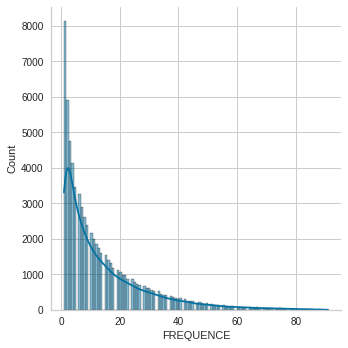

In [184]:
# Checking the histogram of the variable 'FREQUENCE'.

sns.displot(data=ds, x="FREQUENCE", kde=True)
plt.show()

In [185]:
# Calculating the skewness of the 'FREQUENCE' variable.
ds['FREQUENCE'].skew()

1.7749193752664678

The figure above shows that our distribution is right skewed.

### The variable 'DATA_VOLUME':

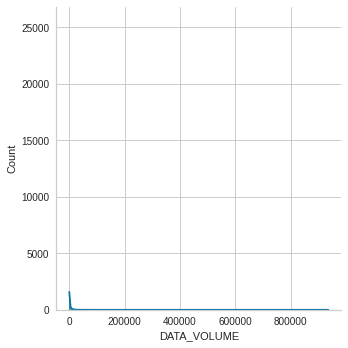

In [186]:
# Checking the histogram of the variable 'DATA_VOLUME'.

sns.displot(data=ds, x="DATA_VOLUME", kde=True)
plt.show()

In [187]:
# Calculating the skewness of the 'DATA_VOLUME' variable.
ds['DATA_VOLUME'].skew()

31.046904770592107

This wierd distribution show the presence of outliers.

### The variable 'ON_NET':

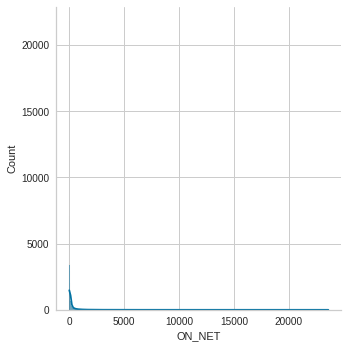

In [188]:
# Checking the histogram of the variable 'ON_NET'.

sns.displot(data=ds, x="ON_NET", kde=True)
plt.show()

In [189]:
# Calculating the skewness of the 'ON_NET' variable.
ds['ON_NET'].skew()

7.790116898216166

This wierd distribution show the presence of outliers.

### The variable 'ORANGE':

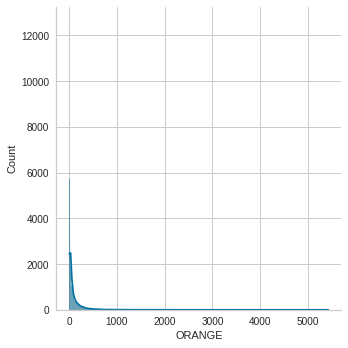

In [190]:
# Checking the histogram of the variable 'ORANGE'.

sns.displot(data=ds, x="ORANGE", kde=True)
plt.show()

In [191]:
# Calculating the skewness of the 'ORANGE' variable.
ds['ORANGE'].skew()

7.038299686385575

The plot above shows a right skewed distribution.

### The variable 'TIGO':

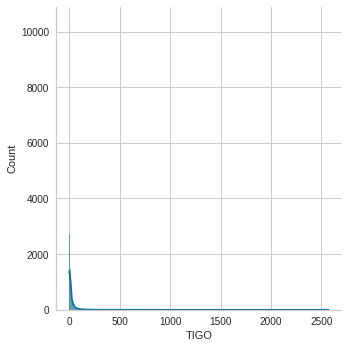

In [192]:
# Checking the histogram of the variable 'TIGO'.

sns.displot(data=ds, x="TIGO", kde=True)
plt.show()

In [193]:
# Calculating the skewness of the 'TIGO' variable.
ds['TIGO'].skew()

13.126422139302584

Again the distribution is right skewed.

### The variable 'ZONE1':

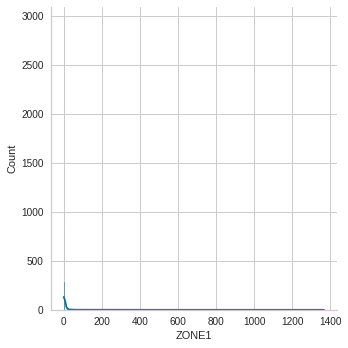

In [194]:
# Checking the histogram of the variable 'ZONE1'.

sns.displot(data=ds, x="ZONE1", kde=True)
plt.show()

In [195]:
# Calculating the skewness of the 'ZONE1' variable.
ds['ZONE1'].skew()

15.95191158014497

Again we end up with a right skewed disribution.

### The variable 'ZONE2'

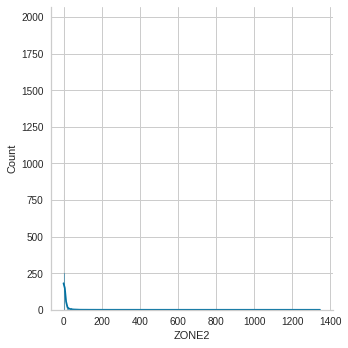

In [196]:
# Checking the histogram of the variable 'ZONE2'.

sns.displot(data=ds, x="ZONE2", kde=True)
plt.show()

In [197]:
# Calculating the skewness of the 'ZONE2' variable.
ds['ZONE2'].skew()

19.482464897224798

The plot above shows a right skewed distribution.

### The variable 'REGULARITY':

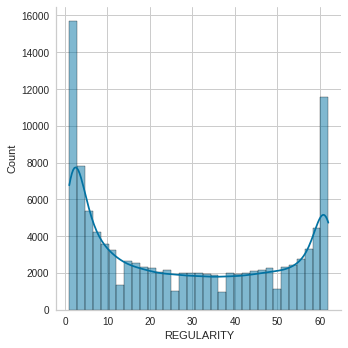

In [198]:
# Checking the histogram of the variable 'REGULARITY'.

sns.displot(data=ds, x="REGULARITY", kde=True)
plt.show()

In [199]:
# Calculating the skewness of the 'REGULARITY' variable.
ds['REGULARITY'].skew()

0.251525157238283

The distribution seems to be concentrated on the extreme values.

### The variable 'FREQ_TOP_PACK':

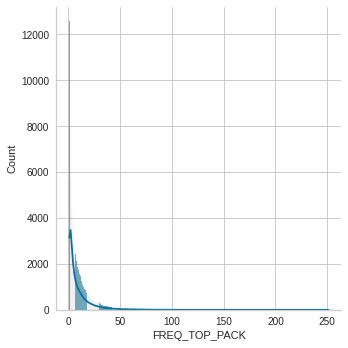

In [200]:
# Checking the histogram of the variable 'FREQ_TOP_PACK'.

sns.displot(data=ds, x="FREQ_TOP_PACK", kde=True)
plt.show()

In [201]:
# Calculating the skewness of the 'FREQ_TOP_PACK' variable.
ds['FREQ_TOP_PACK'].skew()

3.088686378585208

## Spliting the variables into categoricals and numericals.

In [202]:
Num_vars = ds.select_dtypes(include=np.number).columns.tolist()
Num_vars

['MONTANT',
 'FREQUENCE_RECH',
 'REVENUE',
 'ARPU_SEGMENT',
 'FREQUENCE',
 'DATA_VOLUME',
 'ON_NET',
 'ORANGE',
 'TIGO',
 'ZONE1',
 'ZONE2',
 'REGULARITY',
 'FREQ_TOP_PACK',
 'CHURN']

In [203]:
Cat_vars = list(set(ds.columns) - set(Num_vars))
Cat_vars

['TENURE', 'TOP_PACK', 'REGION']

## Variables with missing values.

In [204]:
# We notice is that the target variable "CHURN" has no missing values.
round(100*(ds.isna().sum()/ds.shape[0]), 2)

REGION            39.67
TENURE             0.00
MONTANT           35.15
FREQUENCE_RECH    35.15
REVENUE           33.74
ARPU_SEGMENT      33.74
FREQUENCE         33.74
DATA_VOLUME       49.23
ON_NET            36.64
ORANGE            41.59
TIGO              60.09
ZONE1             92.21
ZONE2             93.72
REGULARITY         0.00
TOP_PACK          41.91
FREQ_TOP_PACK     41.91
CHURN              0.00
dtype: float64

Our target variable 'CHURN' has no missing values.
The variables 'ZONE1' and 'ZONE2' have above 92% missing values.

Only the variables 'TENURE' and 'REGULARITY' does not contain missing values.

##### Categorical variables missing values.

In [205]:
ds['REGION'].fillna("missing", inplace=True)

In [206]:
ds['TOP_PACK'].fillna("others", inplace=True)

##### Numerical variables missing values.

In [207]:
minus_999999 = ['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE',
                'DATA_VOLUME', 'ON_NET', 'ORANGE', 'FREQ_TOP_PACK', 'TIGO', 'ZONE1', 'ZONE2']

In [208]:
for col in minus_999999:
    ds[col].fillna(-99999, inplace=True)

In [209]:
ds['FREQ_TOP_PACK'].fillna(0, inplace=True)

#### Verifying the missing values:

In [210]:
round(100*(ds.isna().sum()/ds.shape[0]), 2)

REGION            0.0
TENURE            0.0
MONTANT           0.0
FREQUENCE_RECH    0.0
REVENUE           0.0
ARPU_SEGMENT      0.0
FREQUENCE         0.0
DATA_VOLUME       0.0
ON_NET            0.0
ORANGE            0.0
TIGO              0.0
ZONE1             0.0
ZONE2             0.0
REGULARITY        0.0
TOP_PACK          0.0
FREQ_TOP_PACK     0.0
CHURN             0.0
dtype: float64

As we can see we do not have any missing values left.

## Correlation between numerical variables.

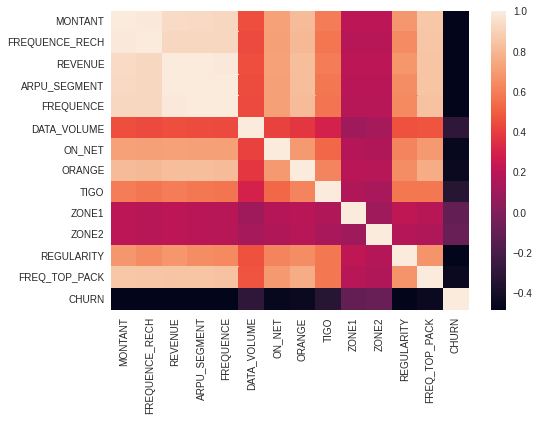

In [211]:
# calculate the correlation matrix
corr = ds.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

plt.show()

In [212]:
corr.style.background_gradient(cmap='coolwarm')

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK,CHURN
MONTANT,1.000000,0.993641,0.930909,0.925155,0.919902,0.453394,0.718048,0.815156,0.598963,0.201716,0.203485,0.682192,0.859607,-0.483321
FREQUENCE_RECH,0.993641,1.000000,0.922296,0.924621,0.923638,0.443078,0.711059,0.807581,0.573043,0.185313,0.184397,0.644803,0.852836,-0.481134
REVENUE,0.930909,0.922296,1.000000,0.997032,0.993073,0.453044,0.719510,0.825195,0.595975,0.202121,0.202565,0.676616,0.849181,-0.483723
ARPU_SEGMENT,0.925155,0.924621,0.997032,1.000000,0.999171,0.446005,0.715244,0.820921,0.578655,0.191137,0.190107,0.651437,0.844402,-0.482587
FREQUENCE,0.919902,0.923638,0.993073,0.999171,1.000000,0.441228,0.711286,0.816707,0.568130,0.184873,0.183079,0.636598,0.839860,-0.480836
DATA_VOLUME,0.453394,0.443078,0.453044,0.446005,0.441228,1.000000,0.416361,0.374936,0.295506,0.105639,0.128295,0.465658,0.467756,-0.298871
ON_NET,0.718048,0.711059,0.719510,0.715244,0.711286,0.416361,1.000000,0.691947,0.524963,0.178936,0.155635,0.621009,0.687705,-0.456427
ORANGE,0.815156,0.807581,0.825195,0.820921,0.816707,0.374936,0.691947,1.000000,0.619937,0.192842,0.185147,0.647365,0.759451,-0.447449
TIGO,0.598963,0.573043,0.595975,0.578655,0.568130,0.295506,0.524963,0.619937,1.000000,0.165030,0.135120,0.577313,0.581984,-0.329348
ZONE1,0.201716,0.185313,0.202121,0.191137,0.184873,0.105639,0.178936,0.192842,0.165030,1.000000,0.103465,0.212876,0.186277,-0.105109


In [213]:
ds.drop(columns=['FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE'], inplace=True)

# Data Preparation:

In [214]:
# Create a modeling dataset from the original dataset
X = ds.copy(deep=True)

## Dealing with outliers.

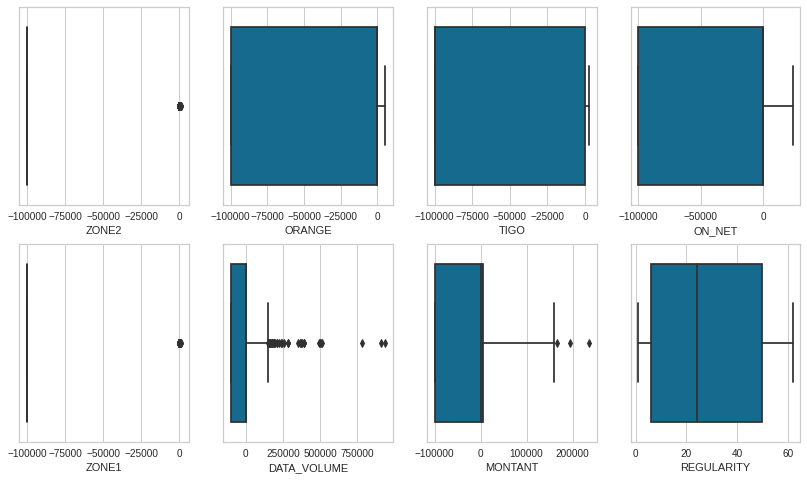

In [215]:
cols = ['ZONE2', 'ORANGE', 'TIGO', 'ON_NET', 'ZONE1', 'DATA_VOLUME', 'MONTANT', 'REGULARITY', 'FREQ_TOP_PACK', 'CHURN']

fig, ax = plt.subplots(2, 4, sharey=True, figsize=(14, 8))
for var, subplot in zip(X[cols], ax.flatten()):
    sns.boxplot(data=ds, x=var, ax=subplot)

In [216]:
X = removeOutliers(X, colList=cols , lowPercentile=0.05, highPercentile=0.95, verbose=True)

        ZONE2   ORANGE     TIGO   ON_NET    ZONE1  DATA_VOLUME  MONTANT  \
0.05 -99999.0 -99999.0 -99999.0 -99999.0 -99999.0     -99999.0 -99999.0   
0.95      0.0    278.0     44.0    871.0      1.0       9185.9  15250.0   

      REGULARITY  FREQ_TOP_PACK  CHURN  
0.05         1.0       -99999.0    0.0  
0.95        62.0           25.0    1.0  


### Mahalanobis distance.

Which data frame should we use df_train or X_train.
Should we scale the variables first, or it is not necessary. 
This part will take too much time, because of the size of the dataset.
I notice that waiting for the algorithm to run makes me anxious.
A way I deal with my anxiety is by breating slowly, that makes me feel less anxious.

In [217]:
#train = pd.concat([X, Y], axis=1, join="inner")

In [218]:
#train[list(num_vars) + ["CHURN"]]

In [219]:
# Number of observations before removing outliers: 43081.

In [220]:
%%time
# Covariance matrix.
#covariance  = np.cov(train[list(num_vars) + ["CHURN"]] , rowvar=False)

# The inverse of the covariance matrix.
#covariance_pm1 = np.linalg.matrix_power(covariance, -1)

# Center poin, which correspond to the mean of each column.
#centerpoint = np.mean(train[list(num_vars) + ["CHURN"]] , axis=0)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs


In [221]:
%%time
# Distances between center point and 

#distances = []
#for i, val in enumerate(train[list(num_vars) + ["CHURN"]].values):
#    p1 = val
#    p2 = centerpoint
#    distance = (p1-p2).T.dot(covariance_pm1).dot(p1-p2)
#    distances.append(distance)

# Converting the distances list into a numpy array.     
#distances = np.array(distances)

# Cutoff (threshold) value from Chi-Sqaure Distribution for detecting outliers 
#cutoff = chi2.ppf(0.95, train[list(num_vars) + ["CHURN"]].shape[1])

# Index of outliers
#outlierIndexes = np.where(distances > cutoff)

#print('--- Index of Outliers ----')
#print(outlierIndexes)

#print('--- Observations found as outlier -----')
#print(train[ distances > cutoff , :])

#train = train.iloc[ distances < cutoff, :]
#X = train.drop(columns=["CHURN"])
#Y = train["CHURN"] 

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


In [222]:
# Removing Outliers using mahalanobis distance takes too much time.

In [223]:
#np.where(distances > cutoff)

In [224]:
#(p1 - p2).T.dot(covariance_pm1).dot(p1-p2)

In [225]:
# After removing outliers we are left with 39962 observations, meaning that we removed  
# 3119 observations.
#X.shape

In [226]:
#After removing outliers we are left with XXX observations.

### Creating new numerical features:

In [227]:
#X[num_vars].columns

In [228]:
#X['MONTANT'] = np.log1p(X['MONTANT'])
#X['FREQUENCE_RECH'] = np.log1p(X['FREQUENCE_RECH'])
#X['REVENUE'] = np.log1p(X['REVENUE'])
#X['ARPU_SEGMENT'] = np.log1p(X['ARPU_SEGMENT'])
#X['FREQUENCE'] = np.log1p(X['FREQUENCE'])
#X['DATA_VOLUME'] = np.log1p(X['DATA_VOLUME'])

#X['ON_NET'] = np.log1p(X['ON_NET'])
#X['ORANGE'] = np.log1p(X['ORANGE'])
#X['TIGO'] = np.log1p(X['TIGO'])
#X['ZONE1'] = np.log1p(X['ZONE1'])
#X['ZONE2'] = np.log1p(X['ZONE2'])
#X['REGULARITY'] = np.log1p(X['REGULARITY'])
#X['FREQ_TOP_PACK'] = np.log1p(X['FREQ_TOP_PACK'])

## Encoding categorical features

Before building our first model we need to encode the categorical features in order to be able to use them in the training of a machine learning model. 

A naive approach is to perform one hot encoding to all categorical features.

But how can I perform one hot encoder to the variable "TOP_PACK", which contains too much categories.

In [229]:
# Encode categorical values into dummy variables.
cols = ['REGION']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

In [230]:
# We perform ordinal encoding 

TENURE_lvl = [['K > 24 month', 'J 21-24 month', 'I 18-21 month','H 15-18 month',
       'G 12-15 month', 'F 9-12 month', 'E 6-9 month', 'D 3-6 month']] 


transformer = make_column_transformer(
    (OrdinalEncoder(categories=TENURE_lvl), ['TENURE']))

# "verification_status"
X[["TENURE"]] = pd.DataFrame(transformer.fit_transform(X),
                          columns = ["TENURE"], index = X.index)

In [231]:
le = preprocessing.LabelEncoder()
X["TOP_PACK"] = le.fit_transform(X["TOP_PACK"])

## Robust Scaler for the numerical variables:

In [232]:
cols=['MONTANT', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 
      'ZONE1', 'ZONE2', 'REGULARITY', 'FREQ_TOP_PACK']


X[cols] = pd.DataFrame(RobustScaler().fit_transform(X[cols]),
                          columns = cols, index = X.index)

## Dealing with class imbalance.

In this part I can use SMOTE even if im not a big fan of it, but let see what happens. 

## Defining the target variable

In [233]:
# Defining the target variable.

y = X['CHURN'] 
X  = X.drop(columns=['CHURN'])

# Modelling:

In [234]:
# Split the dataset intro train and test sets.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle =True,
                                                    stratify=y, random_state=2022)

## Logistic Regression

In [235]:
%%time

# Initializing the model.

modelLR = linear_model.LogisticRegression(random_state=2022)

# Creating and training the model.

modelLR.fit(X_train, y_train)

# Predicting the target for X_train and X_test.

y_pred_train = modelLR.predict(X_train) 
y_pred_test = modelLR.predict(X_test) 

# Probabilities of belong to the class 1.
y_pred_proba_train = modelLR.predict_proba(X_train)[:,1] 
y_pred_proba_test = modelLR.predict_proba(X_test)[:,1] 

print('\nAccuracy Score for modelLR: ', accuracy_score(y_pred_test, y_test))



Accuracy Score for modelLR:  0.8402249033618368
CPU times: user 1.95 s, sys: 933 ms, total: 2.89 s
Wall time: 1.55 s


ClassificationReport(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b6dd24ad0>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x7f7b3952de90>,
                     estimator=LogisticRegression(random_state=2022),
                     support=True)

0.8402249033618368

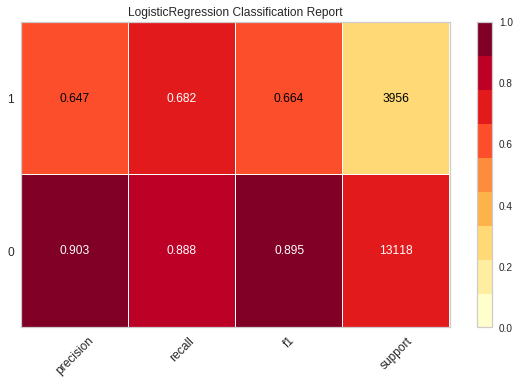

In [236]:
visualizer = ClassificationReport(modelLR, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

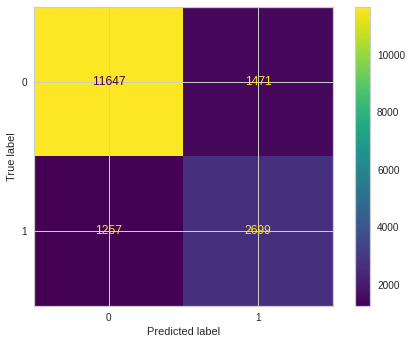

In [237]:
# Show the confusion matrix

cm = confusion_matrix(y_test, y_pred_test, labels=modelLR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=modelLR.classes_)
disp.plot()

plt.show()

In [238]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_proba_train, y_pred_train, y_test, y_pred_proba_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,ACCURACY,0.838465,0.840225
1,PRECISION,0.643860,0.647242
2,RECALL,0.838465,0.840225
3,F1 SCORE,0.839895,0.841672
4,AUC,0.782388,0.785059
5,AUC_Proba,0.884996,0.889212


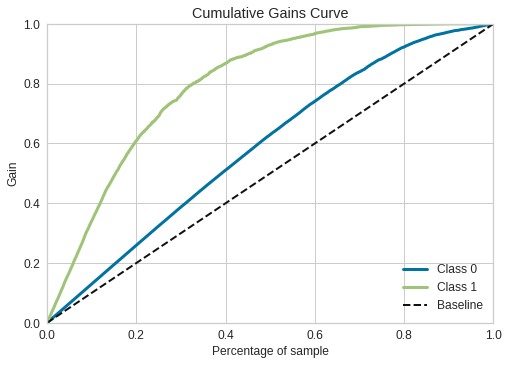

In [239]:
# Ploting the cumulative gains curve.

skplt.metrics.plot_cumulative_gain(y_test, modelLR.predict_proba(X_test))

## Random Forest

In [240]:
# Initializing the model.

modelRF = RandomForestClassifier(max_depth=10, random_state=2022)

# Creating and training the model.

modelRF.fit(X_train, y_train)

# Predicting the target for X_train and X_test.

y_pred_train = modelRF.predict(X_train) 
y_pred_test = modelRF.predict(X_test) 

# Probabilities of belong to the class 1.
y_pred_proba_train = modelRF.predict_proba(X_train)[:,1] 
y_pred_proba_test = modelRF.predict_proba(X_test)[:,1] 

print('\nAccuracy Score for modelRF: ', accuracy_score(y_pred_test, y_test))

RandomForestClassifier(max_depth=10, random_state=2022)


Accuracy Score for modelRF:  0.855277029401429


ClassificationReport(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b3931c2d0>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x7f7b3931c490>,
                     estimator=RandomForestClassifier(max_depth=10,
                                                      random_state=2022),
                     support=True)

0.855277029401429

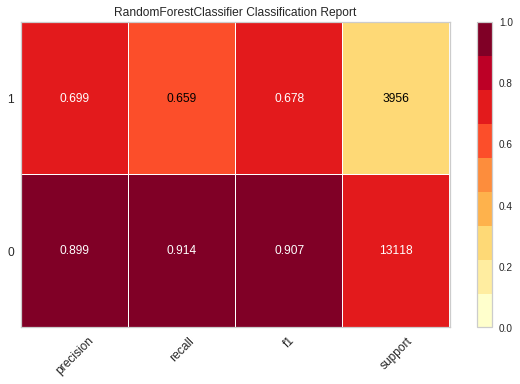

In [241]:
visualizer = ClassificationReport(modelRF, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

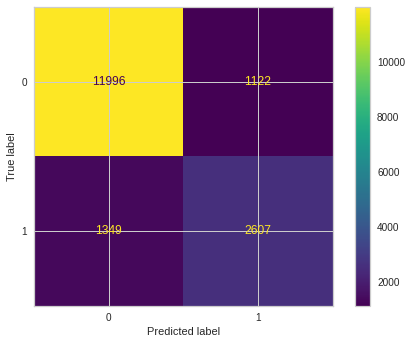

In [242]:
# Show the confusion matrix

cm = confusion_matrix(y_test, y_pred_test, labels=modelRF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=modelLR.classes_)
disp.plot()

plt.show()

In [243]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_proba_train, y_pred_train, y_test, y_pred_proba_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,ACCURACY,0.856300,0.855277
1,PRECISION,0.699231,0.699115
2,RECALL,0.856300,0.855277
3,F1 SCORE,0.855086,0.853760
4,AUC,0.790068,0.786734
5,AUC_Proba,0.922261,0.917020


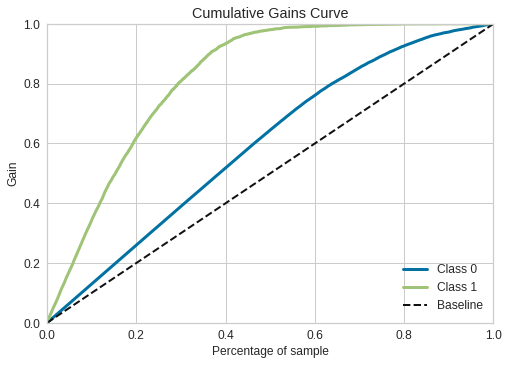

In [244]:
# Ploting the cumulative gains curve.

skplt.metrics.plot_cumulative_gain(y_test, modelRF.predict_proba(X_test))

## Imbalanced learn algorithms.

In [245]:
!pip install imblearn

In [246]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier

### Balanced Random Forest:

In [247]:
# Initializing the model.

modelBRF = BalancedRandomForestClassifier(max_depth=10, random_state=2022)

# Creating and training the model.

modelBRF.fit(X_train, y_train)

# Predicting the target for X_train and X_test.

y_pred_train = modelBRF.predict(X_train) 
y_pred_test = modelBRF.predict(X_test) 

# Probabilities of belong to the class 1.
y_pred_proba_train = modelBRF.predict_proba(X_train)[:,1] 
y_pred_proba_test = modelBRF.predict_proba(X_test)[:,1] 

print('\nAccuracy Score for modelBRF: ', accuracy_score(y_pred_test, y_test))

BalancedRandomForestClassifier(max_depth=10, random_state=2022)


Accuracy Score for modelBRF:  0.8144547264847136


ClassificationReport(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b39072610>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x7f7b39072410>,
                     estimator=BalancedRandomForestClassifier(max_depth=10,
                                                              random_state=2022),
                     support=True)

0.8144547264847136

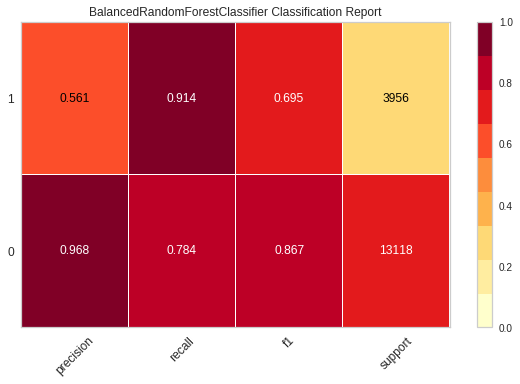

In [248]:
visualizer = ClassificationReport(modelBRF, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

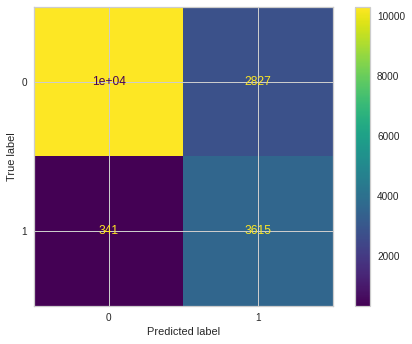

In [249]:
# Show the confusion matrix

cm = confusion_matrix(y_test, y_pred_test, labels=modelBRF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=modelBRF.classes_)
disp.plot()

plt.show()

In [250]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_proba_train, y_pred_train, y_test, y_pred_proba_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,ACCURACY,0.817044,0.814455
1,PRECISION,0.564208,0.561161
2,RECALL,0.817044,0.814455
3,F1 SCORE,0.829438,0.826924
4,AUC,0.854651,0.849148
5,AUC_Proba,0.920358,0.917043


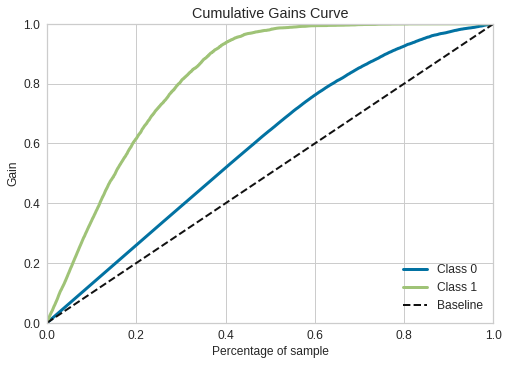

In [251]:
# Ploting the cumulative gains curve.

skplt.metrics.plot_cumulative_gain(y_test, modelBRF.predict_proba(X_test))

## Random Forest Classifier with Random Under Sampler:

In [252]:
# Initializing the model.

modelRF2 = make_pipeline(
    RandomUnderSampler(sampling_strategy='auto', replacement=False, random_state=2022),
    RandomForestClassifier(n_estimators=500, max_depth=10,
                           min_samples_split=8, random_state=2022, n_jobs=-1),
    )

# Creating and training the model.

modelRF2.fit(X_train, y_train)

# Predicting the target for X_train and X_test.

y_pred_train = modelRF2.predict(X_train) 
y_pred_test = modelRF2.predict(X_test) 

# Probabilities of belong to the class 1.
y_pred_proba_train = modelRF2.predict_proba(X_train)[:,1] 
y_pred_proba_test = modelRF2.predict_proba(X_test)[:,1] 

print('\nAccuracy Score for modelRF2: ', accuracy_score(y_pred_test, y_test))

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=2022)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=8,
                                        n_estimators=500, n_jobs=-1,
                                        random_state=2022))])


Accuracy Score for modelRF2:  0.8149232751552068


ClassificationReport(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b38ee6990>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x7f7b38ee6d90>,
                     estimator=Pipeline(steps=[('randomundersampler',
                                                RandomUnderSampler(random_state=2022)),
                                               ('randomforestclassifier',
                                                RandomForestClassifier(max_depth=10,
                                                                       min_samples_split=8,
                                                                       n_estimators=500,
                                                                       n_jobs=-1,
                                                                       random_state=2022))]),
                     support=True)

0.8149232751552068

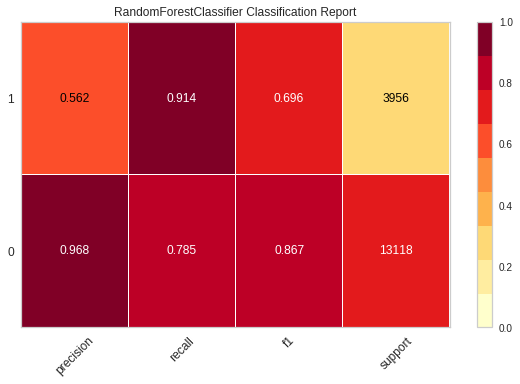

In [253]:
visualizer = ClassificationReport(modelRF2, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

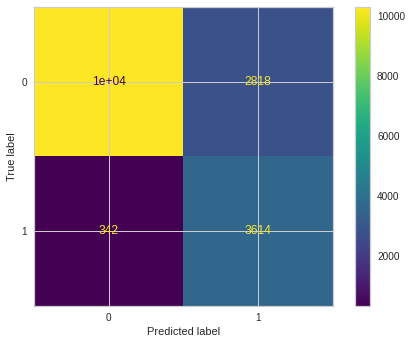

In [254]:
# Show the confusion matrix

cm = confusion_matrix(y_test, y_pred_test, labels=modelRF2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=modelRF2.classes_)
disp.plot()

plt.show()

In [255]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_proba_train, y_pred_train, y_test, y_pred_proba_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,ACCURACY,0.816224,0.814923
1,PRECISION,0.563408,0.561878
2,RECALL,0.816224,0.814923
3,F1 SCORE,0.828605,0.827337
4,AUC,0.852242,0.849365
5,AUC_Proba,0.919396,0.916914


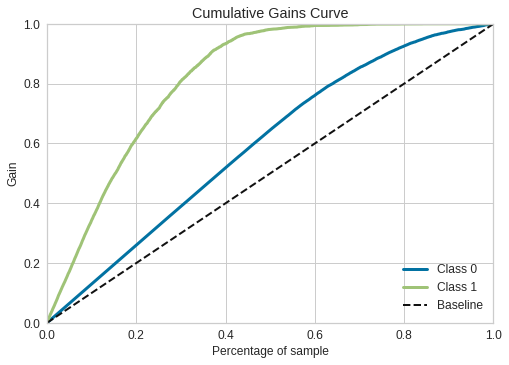

In [256]:
# Ploting the cumulative gains curve.

skplt.metrics.plot_cumulative_gain(y_test, modelRF2.predict_proba(X_test))

## Balanced Random Forest Classifier with Random Under Sampler:

In [257]:
# Initializing the model.

modelBRF2 = make_pipeline(
    RandomUnderSampler(random_state=2022),
    BalancedRandomForestClassifier(n_estimators=500, random_state=2022, n_jobs=-1),
    )

# Creating and training the model.

modelBRF2.fit(X_train, y_train)

# Predicting the target for X_train and X_test.

y_pred_train = modelBRF2.predict(X_train) 
y_pred_test = modelBRF2.predict(X_test) 

# Probabilities of belong to the class 1.
y_pred_proba_train = modelBRF2.predict_proba(X_train)[:,1] 
y_pred_proba_test = modelBRF2.predict_proba(X_test)[:,1] 

print('\nAccuracy Score for modelBRF2: ', accuracy_score(y_pred_test, y_test))

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=2022)),
                ('balancedrandomforestclassifier',
                 BalancedRandomForestClassifier(n_estimators=500, n_jobs=-1,
                                                random_state=2022))])


Accuracy Score for modelBRF2:  0.8128733747217992


ClassificationReport(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b4c6bcd10>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x7f7b4c6bcf90>,
                     estimator=Pipeline(steps=[('randomundersampler',
                                                RandomUnderSampler(random_state=2022)),
                                               ('balancedrandomforestclassifier',
                                                BalancedRandomForestClassifier(n_estimators=500,
                                                                               n_jobs=-1,
                                                                               random_state=2022))]),
                     support=True)

0.8128733747217992

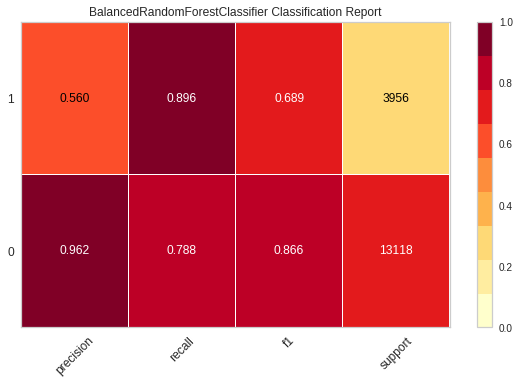

In [258]:
visualizer = ClassificationReport(modelBRF2, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

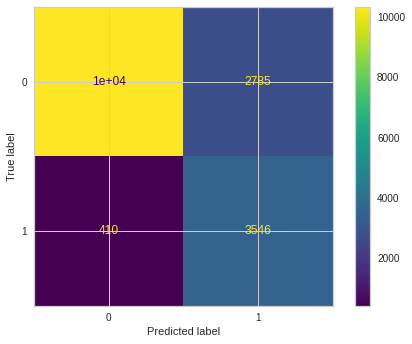

In [259]:
# Show the confusion matrix

cm = confusion_matrix(y_test, y_pred_test, labels=modelBRF2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=modelBRF2.classes_)
disp.plot()

plt.show()

In [260]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_proba_train, y_pred_train, y_test, y_pred_proba_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,ACCURACY,0.846753,0.812873
1,PRECISION,0.604215,0.560101
2,RECALL,0.846753,0.812873
3,F1 SCORE,0.857022,0.825162
4,AUC,0.893910,0.842028
5,AUC_Proba,0.940172,0.907017


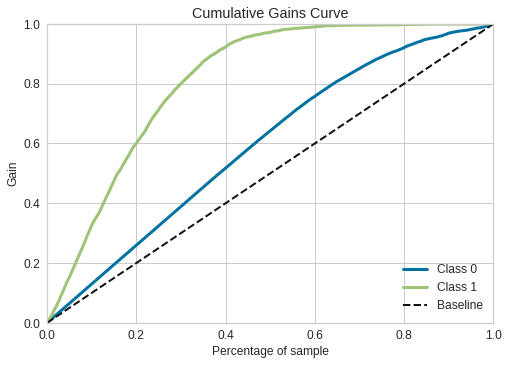

In [261]:
# Ploting the cumulative gains curve.

skplt.metrics.plot_cumulative_gain(y_test, modelBRF2.predict_proba(X_test))

##  Gradient Boosting Classifier with Random Under Sampler:

In [262]:
# Initializing the model.

modelGB = make_pipeline(
    RandomUnderSampler(random_state=2022),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                random_state=2022),
)

# Creating and training the model.

modelGB.fit(X_train, y_train)

# Predicting the target for X_train and X_test.

y_pred_train = modelGB.predict(X_train) 
y_pred_test = modelGB.predict(X_test) 

# Probabilities of belong to the class 1.
y_pred_proba_train = modelGB.predict_proba(X_train)[:,1] 
y_pred_proba_test = modelGB.predict_proba(X_test)[:,1] 

print('\nAccuracy Score for modelGB: ', accuracy_score(y_pred_test, y_test))

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=2022)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=1.0,
                                            random_state=2022))])


Accuracy Score for modelGB:  0.8073679278435048


ClassificationReport(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b4c55d990>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x7f7b4c55d350>,
                     estimator=Pipeline(steps=[('randomundersampler',
                                                RandomUnderSampler(random_state=2022)),
                                               ('gradientboostingclassifier',
                                                GradientBoostingClassifier(learning_rate=1.0,
                                                                           random_state=2022))]),
                     support=True)

0.8073679278435048

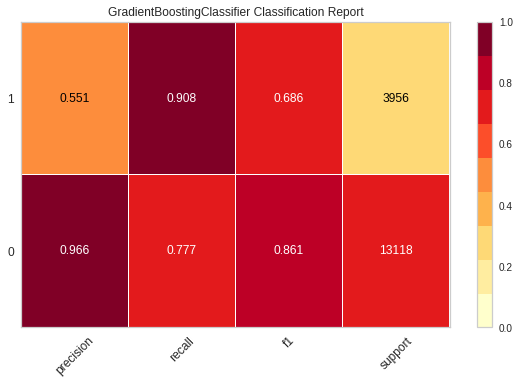

In [263]:
visualizer = ClassificationReport(modelGB, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

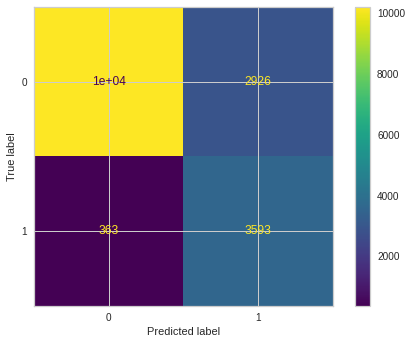

In [264]:
# Show the confusion matrix

cm = confusion_matrix(y_test, y_pred_test, labels=modelGB.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=modelGB.classes_)
disp.plot()

plt.show()

In [265]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_proba_train, y_pred_train, y_test, y_pred_proba_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,ACCURACY,0.813940,0.807368
1,PRECISION,0.559344,0.551158
2,RECALL,0.813940,0.807368
3,F1 SCORE,0.826743,0.820506
4,AUC,0.854043,0.842594
5,AUC_Proba,0.916455,0.908389


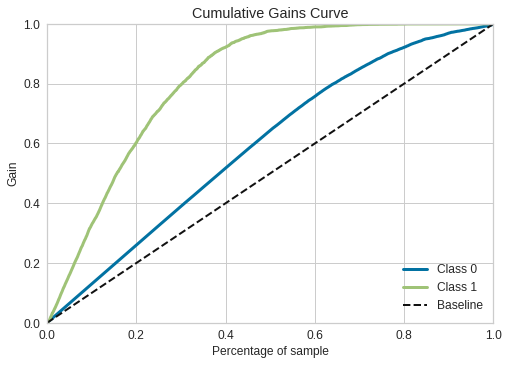

In [266]:
# Ploting the cumulative gains curve.

skplt.metrics.plot_cumulative_gain(y_test, modelGB.predict_proba(X_test))

## XGboost Classifier with Random Under Sampler:

In [267]:
# Create object and train the model
modelXGB = xgboost.XGBClassifier(n_estimators=300,
                           subsample=0.9,
                           colsample_bytree=0.9,
                           max_depth=3,
                           eval_metric='error',
                           seed=123,
                           scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1],
                           use_label_encoder=False
                           )

# Creating and training the model.

modelXGB.fit(X_train, y_train)

# Predicting the target for X_train and X_test.

y_pred_train = modelXGB.predict(X_train) 
y_pred_test = modelXGB.predict(X_test) 

# Probabilities of belong to the class 1.
y_pred_proba_train = modelXGB.predict_proba(X_train)[:,1] 
y_pred_proba_test = modelXGB.predict_proba(X_test)[:,1] 

print('\nAccuracy Score for modelXGB: ', accuracy_score(y_pred_test, y_test))

XGBClassifier(colsample_bytree=0.9, eval_metric='error', n_estimators=300,
              scale_pos_weight=3.315367117401744, seed=123, subsample=0.9,
              use_label_encoder=False)


Accuracy Score for modelXGB:  0.8163874897504978


ClassificationReport(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b4c3459d0>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x7f7b4c355150>,
                     estimator=XGBClassifier(colsample_bytree=0.9,
                                             eval_metric='error',
                                             n_estimators=300,
                                             scale_pos_weight=3.315367117401744,
                                             seed=123, subsample=0.9,
                                             use_label_encoder=False),
                     support=True)

0.8163874897504978

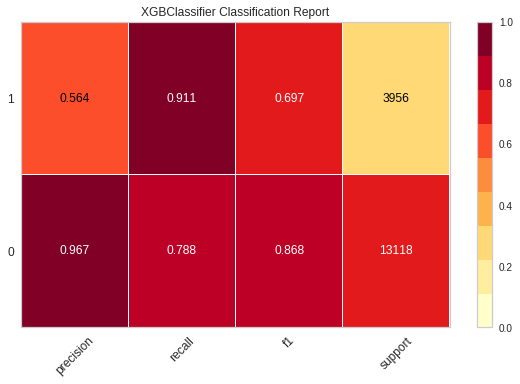

In [268]:
visualizer = ClassificationReport(modelXGB, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

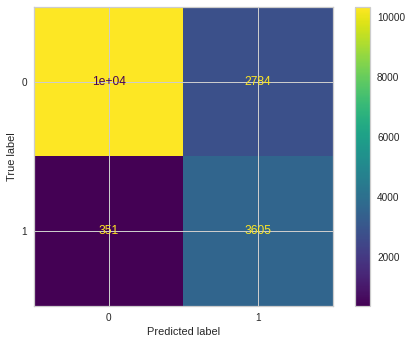

In [269]:
# Show the confusion matrix

cm = confusion_matrix(y_test, y_pred_test, labels=modelXGB.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=modelXGB.classes_)
disp.plot()

plt.show()

In [270]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_proba_train, y_pred_train, y_test, y_pred_proba_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,ACCURACY,0.815902,0.816387
1,PRECISION,0.563217,0.564251
2,RECALL,0.815902,0.816387
3,F1 SCORE,0.828246,0.828595
4,AUC,0.850731,0.849523
5,AUC_Proba,0.918126,0.917513


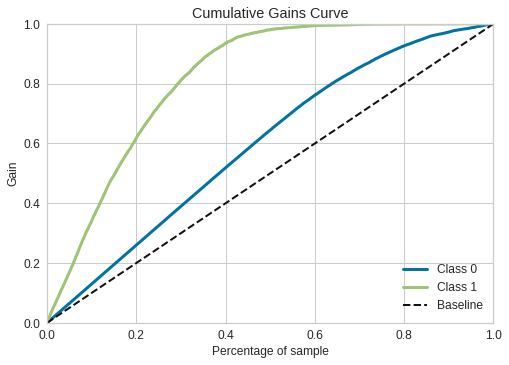

In [271]:
# Ploting the cumulative gains curve.

skplt.metrics.plot_cumulative_gain(y_test, modelXGB.predict_proba(X_test))

Text(0.5, 1.0, 'xgboost feature importance - gain')

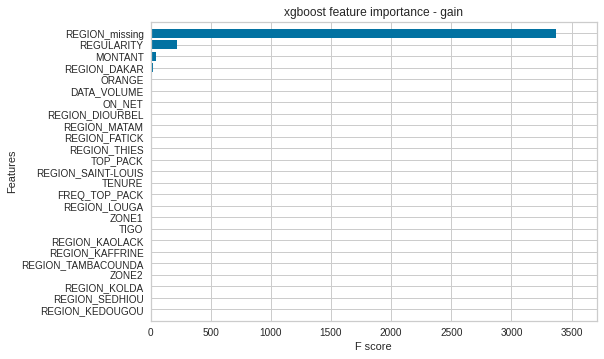

In [272]:
# Gain - The average training loss reduction gained when using a feature for splitting
xgboost.plot_importance(modelXGB, importance_type="gain", show_values=False, height=0.8)
plt.title("xgboost feature importance - gain")
plt.show()

### Model explanation using Shap

Uses Tree SHAP algorithms to explain the output of ensemble tree models.

In [273]:
!pip install shap

In [274]:
import shap

In [275]:
# Creating Shap
explainer = shap.TreeExplainer(modelXGB)
shap_values = explainer.shap_values(X_train, y=y_train)

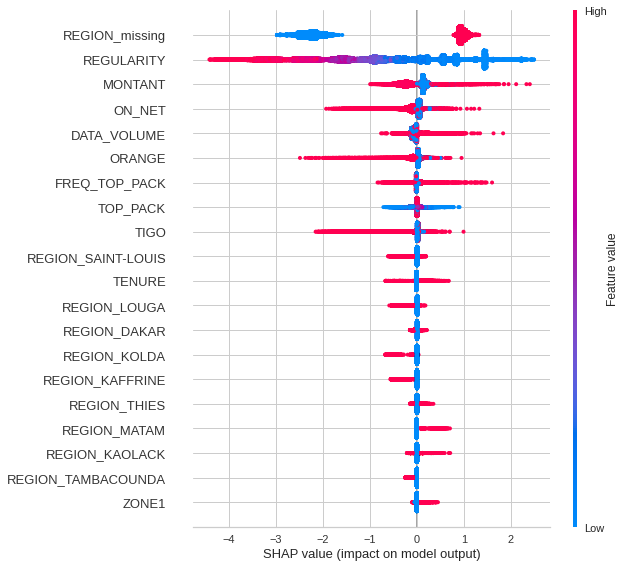

In [276]:
# Shap summary
shap.summary_plot(shap_values, X_train)

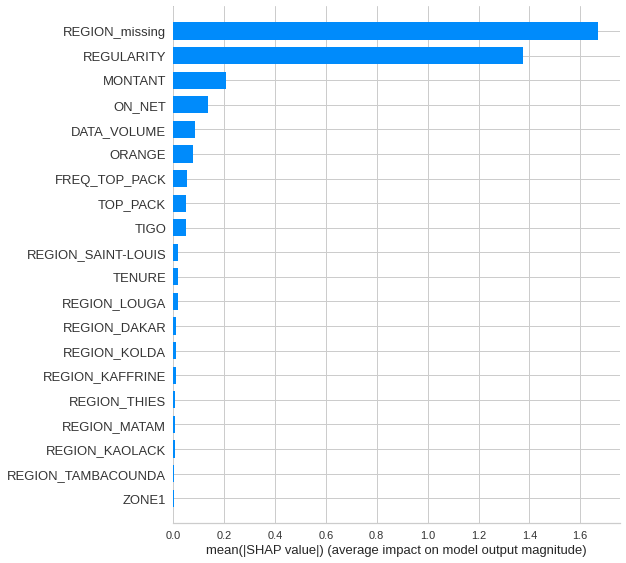

In [277]:
# Mean importance
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [278]:
# Visualizing some of instances - let's see the first 500
# Interact with menu to explore the results
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:500,:], X_train.iloc[:500,:])

In [279]:
# Visualizing one instance only (first customer - index 0)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

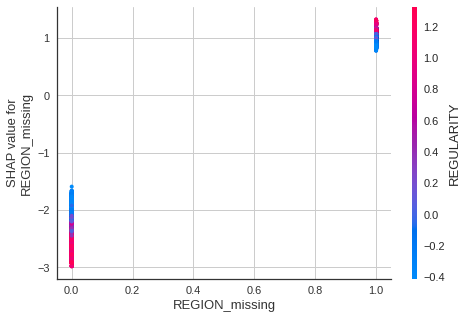

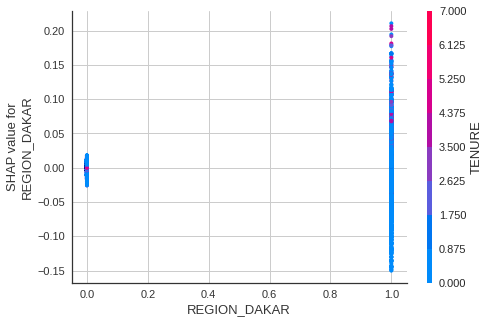

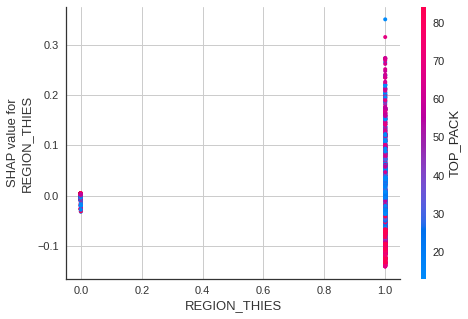

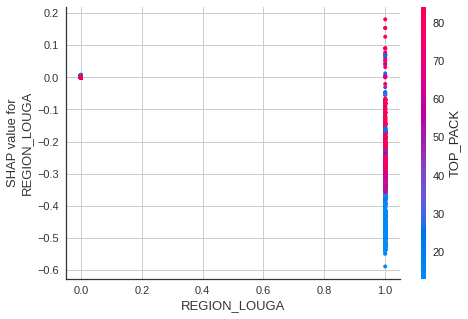

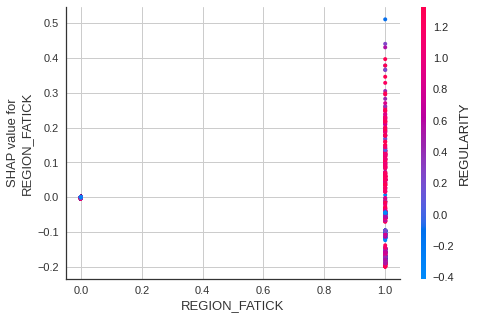

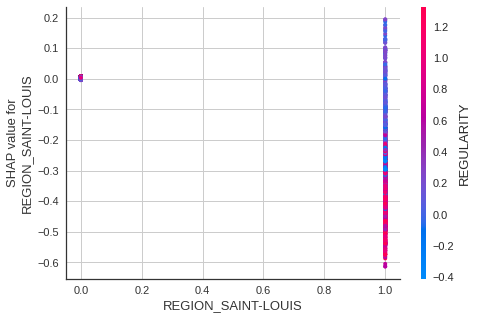

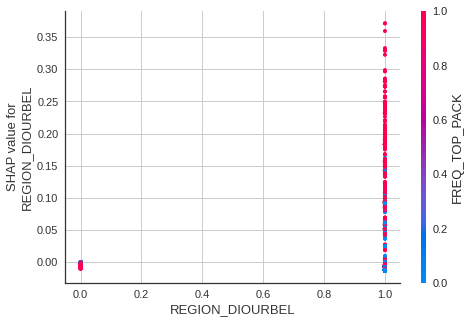

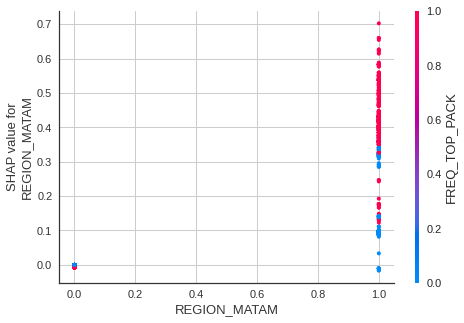

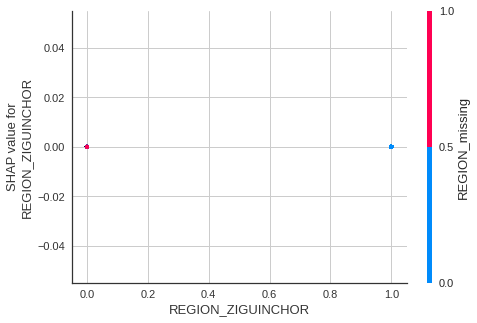

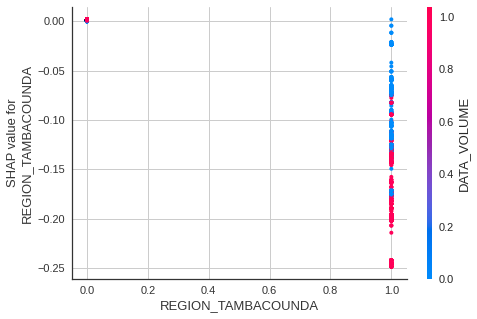

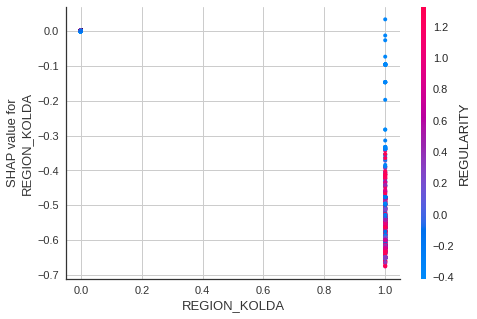

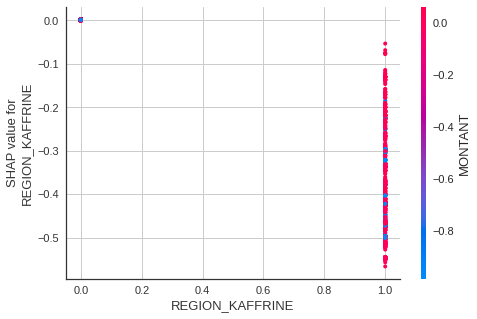

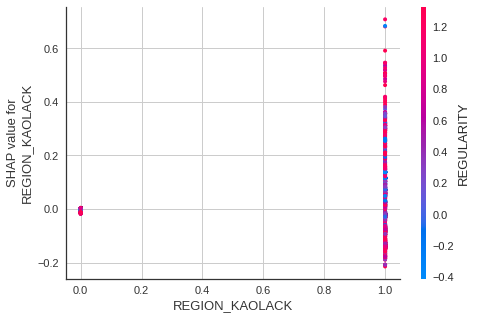

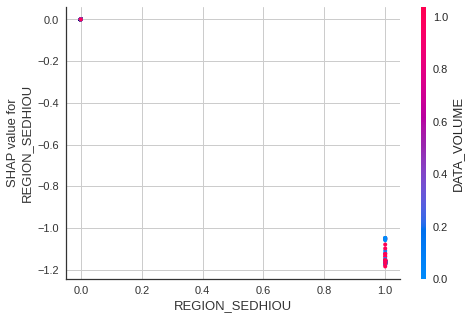

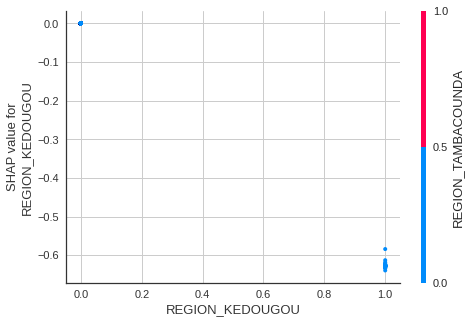

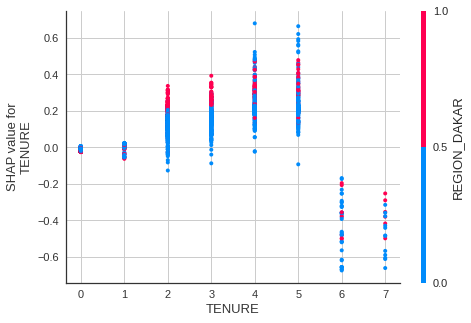

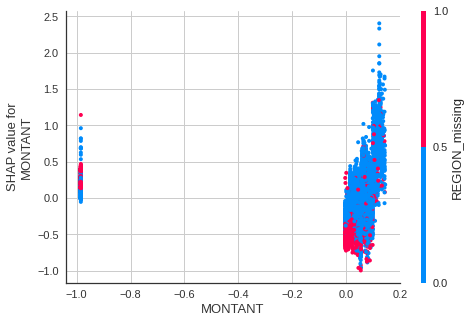

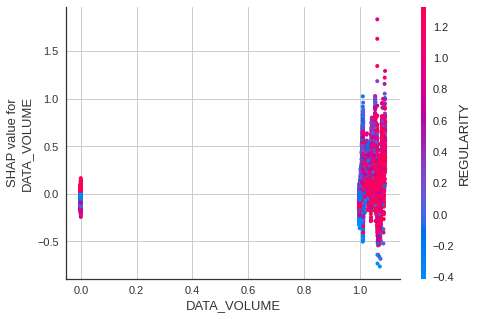

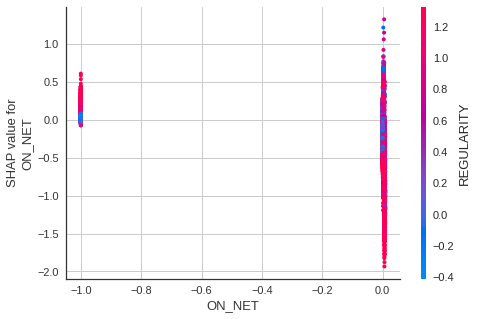

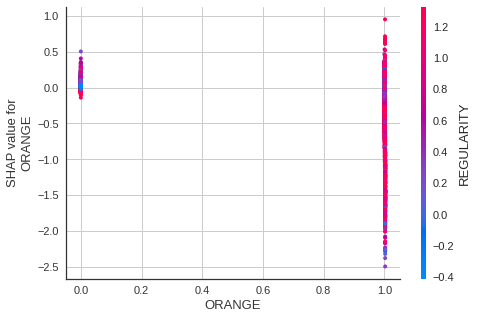

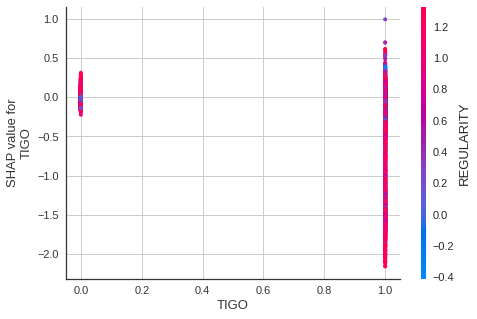

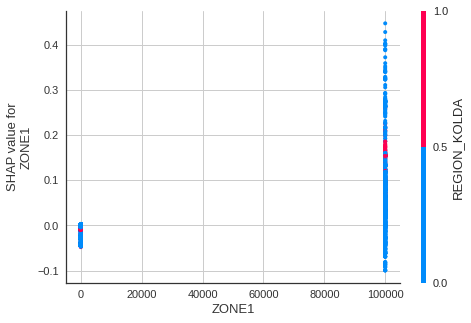

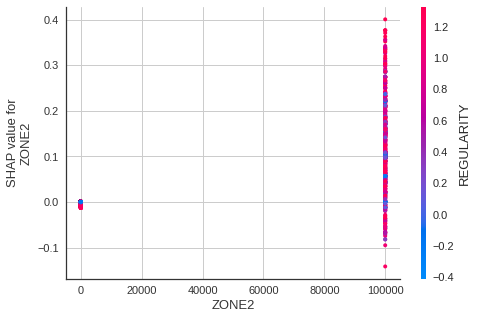

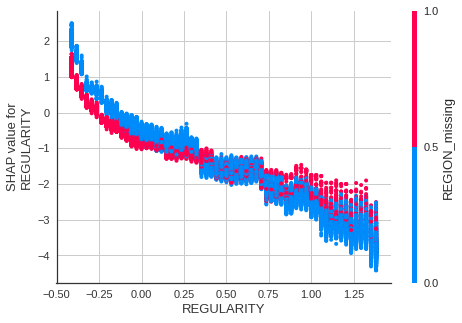

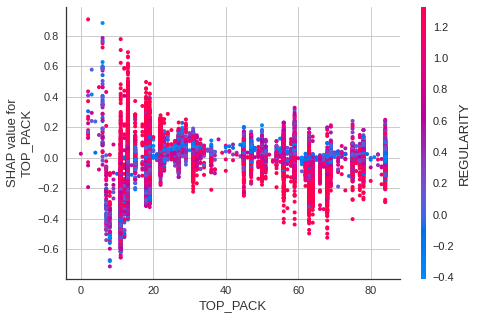

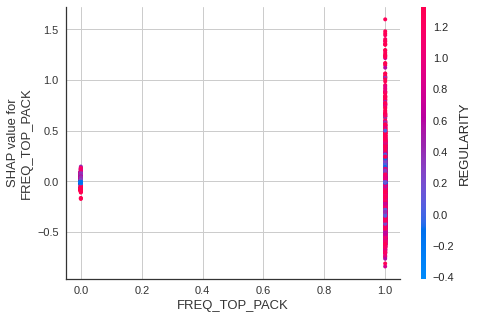

In [280]:
# Check the dependence between the different features
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train)

## LR Stacking

In [281]:
models = [    
    ("GB", GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                random_state=2022)
    ),
    ("XGB", xgboost.XGBClassifier(n_estimators=300,
                           subsample=0.9,
                           colsample_bytree=0.9,
                           max_depth=3,
                           eval_metric='error',
                           seed=123,
                           scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1],
                           use_label_encoder=False
                           )
    )

]
modelSLR = StackingClassifier(
    estimators=models, final_estimator=linear_model.LogisticRegression(random_state=2022)
)

# Creating and training the model.

modelSLR.fit(X_train, y_train)

# Predicting the target for X_train and X_test.

y_pred_train = modelSLR.predict(X_train) 
y_pred_test = modelSLR.predict(X_test) 

# Probabilities of belong to the class 1.
y_pred_proba_train = modelSLR.predict_proba(X_train)[:,1] 
y_pred_proba_test = modelSLR.predict_proba(X_test)[:,1] 

print('\nAccuracy Score for modelSLR: ', accuracy_score(y_pred_test, y_test))

StackingClassifier(estimators=[('GB',
                                GradientBoostingClassifier(learning_rate=1.0,
                                                           random_state=2022)),
                               ('XGB',
                                XGBClassifier(colsample_bytree=0.9,
                                              eval_metric='error',
                                              n_estimators=300,
                                              scale_pos_weight=3.315367117401744,
                                              seed=123, subsample=0.9,
                                              use_label_encoder=False))],
                   final_estimator=LogisticRegression(random_state=2022))


Accuracy Score for modelSLR:  0.854632774979501


ClassificationReport(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b36a2f390>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x7f7b36a2f550>,
                     estimator=StackingClassifier(estimators=[('GB',
                                                               GradientBoostingClassifier(learning_rate=1.0,
                                                                                          random_state=2022)),
                                                              ('XGB',
                                                               XGBClassifier(colsample_bytree=0.9,
                                                                             eval_metric='error',
                                                                             n_estimators=300,
                                                                             scale_pos_weight=3.315367117401744,
                                                           

0.854632774979501

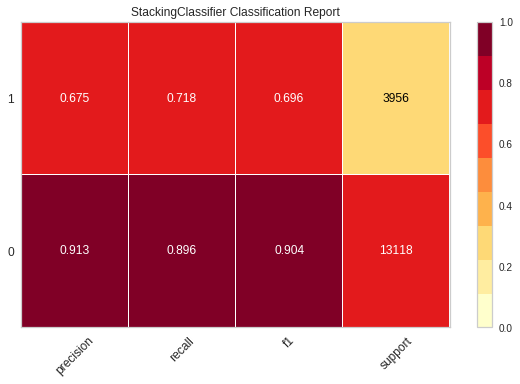

In [282]:
visualizer = ClassificationReport(modelSLR, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

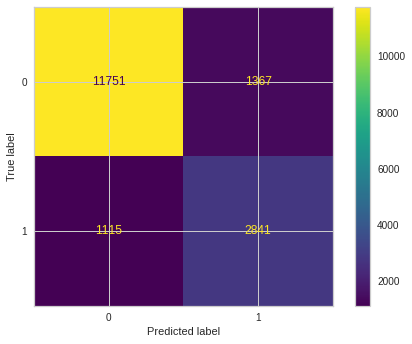

In [283]:
# Show the confusion matrix

cm = confusion_matrix(y_test, y_pred_test, labels=modelSLR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=modelLR.classes_)
disp.plot()

plt.show()

In [284]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_proba_train, y_pred_train, y_test, y_pred_proba_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,ACCURACY,0.854470,0.854633
1,PRECISION,0.673504,0.675143
2,RECALL,0.854470,0.854633
3,F1 SCORE,0.856199,0.856171
4,AUC,0.808205,0.806971
5,AUC_Proba,0.918493,0.917575


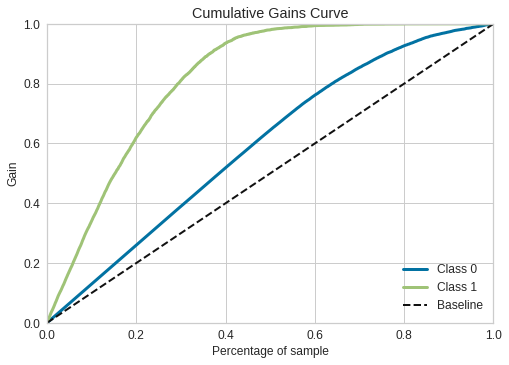

In [285]:
# Ploting the cumulative gains curve.

skplt.metrics.plot_cumulative_gain(y_test, modelSLR.predict_proba(X_test))

## GP Stacking

In [286]:
%%time
models = [    
    ("GB", GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                random_state=2022)
    ),
    ("XGB", xgboost.XGBClassifier(n_estimators=300,
                           subsample=0.9,
                           colsample_bytree=0.9,
                           max_depth=3,
                           eval_metric='error',
                           seed=123,
                           scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1],
                           use_label_encoder=False
                           )
    )

]

modelSGP = StackingClassifier(
    estimators=models, final_estimator=SymbolicClassifier(
                        population_size=100,
                        generations=500,
                        tournament_size=10,
                        parsimony_coefficient=0.01, #0.001,
                        random_state=10,
                        )
)


# Creating and training the model.

modelSGP.fit(X_train, y_train)

# Predicting the target for X_train and X_test.

y_pred_train = modelSGP.predict(X_train) 
y_pred_test = modelSGP.predict(X_test) 

# Probabilities of belong to the class 1.
y_pred_proba_train = modelSGP.predict_proba(X_train)[:,1] 
y_pred_proba_test = modelSGP.predict_proba(X_test)[:,1] 

print('\nAccuracy Score for modelSGP: ', accuracy_score(y_pred_test, y_test))


Accuracy Score for modelSGP:  0.8541056577251962
CPU times: user 10min 36s, sys: 10.9 s, total: 10min 47s
Wall time: 10min 44s


ClassificationReport(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b4b4f59d0>,
                     cmap=<matplotlib.colors.ListedColormap object at 0x7f7b368de050>,
                     estimator=StackingClassifier(estimators=[('GB',
                                                               GradientBoostingClassifier(learning_rate=1.0,
                                                                                          random_state=2022)),
                                                              ('XGB',
                                                               XGBClassifier(colsample_bytree=0.9,
                                                                             eval_metric='error',
                                                                             n_estimators=300,
                                                                             scale_pos_weight=3.315367117401744,
                                                           

0.8541056577251962

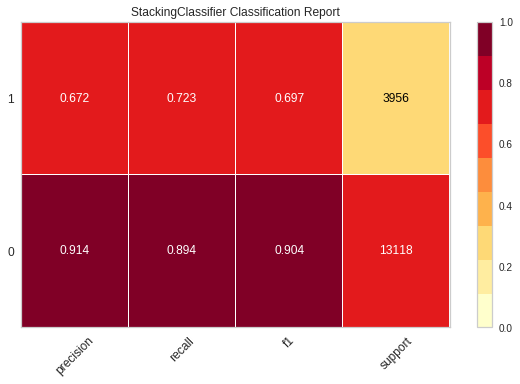

In [287]:
visualizer = ClassificationReport(modelSGP, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure
plt.show()

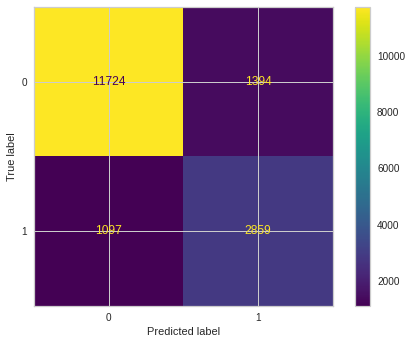

In [288]:
# Show the confusion matrix

cm = confusion_matrix(y_test, y_pred_test, labels=modelSGP.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=modelLR.classes_)
disp.plot()

plt.show()

In [289]:
# Showing the results performance.

resultsDF = performanceMetricsDF(metrics, y_train, y_pred_proba_train, y_pred_train, y_test, y_pred_proba_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,ACCURACY,0.853518,0.854106
1,PRECISION,0.669876,0.672231
2,RECALL,0.853518,0.854106
3,F1 SCORE,0.855503,0.855910
4,AUC,0.808755,0.808217
5,AUC_Proba,0.918126,0.917513


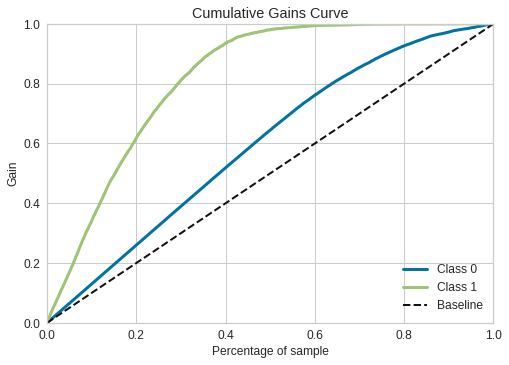

In [290]:
# Ploting the cumulative gains curve.

skplt.metrics.plot_cumulative_gain(y_test, modelSGP.predict_proba(X_test))

# Comparing the Classifiers:

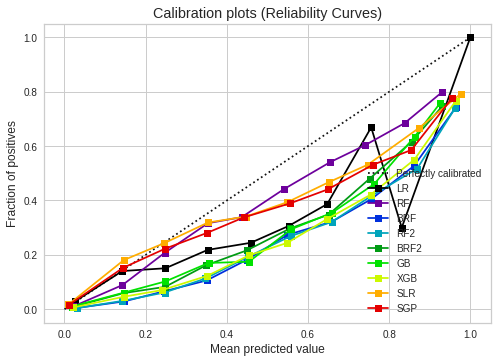

In [291]:
LR_probas = modelLR.predict_proba(X_test)
RF_probas = modelRF.predict_proba(X_test)
BRF_probas = modelBRF.predict_proba(X_test)
RF2_probas = modelRF2.predict_proba(X_test)
BRF2_probas = modelBRF2.predict_proba(X_test)
GB_probas = modelGB.predict_proba(X_test)
XGB_probas = modelXGB.predict_proba(X_test)
SLR_probas = modelSLR.predict_proba(X_test)
SGP_probas = modelSGP.predict_proba(X_test)


probas_list = [LR_probas, RF_probas, BRF_probas, RF2_probas, BRF2_probas,
               GB_probas, XGB_probas, SLR_probas, SGP_probas]
model_names = ['LR', 'RF', 'BRF', 'RF2', 'BRF2', 'GB', 'XGB', 'SLR', 'SGP']
skplt.metrics.plot_calibration_curve(y_test, probas_list, model_names)
plt.show()

## CatBoost

In [292]:
#X_train, X_validation, Y_train, Y_validation = train_test_split(
#    X, Y, test_size=0.33, stratify=Y, random_state=2022)

In [293]:
#model_CBC = CatBoostClassifier(n_estimators=1000,eval_metric='Logloss',random_seed= 10)
#model_CBC.fit(X_train,Y_train, early_stopping_rounds=100,verbose=100)
#print(model_CBC)

In [294]:
# The auc varies if i choose predict or predict_proba, why is that ...
# https://stackoverflow.com/questions/56397128/roc-auc-score-is-different-while-calculating-using-predict-vs-predict-proba

#Y_validation_predict = model_CBC.predict_proba(X_validation)[:,1] 
#print("auc: ", roc_auc_score(Y_validation, Y_validation_predict))

In [295]:
#cm = confusion_matrix(Y_validation, Y_validation_predict)
#cm

In [296]:
#ax= plt.subplot()
#sns.heatmap(cm, annot=True, fmt='g', ax=ax)  
# labels, title and ticks
#ax.set_xlabel('Predicted labels')
#ax.set_ylabel('True labels')
#ax.set_title('Confusion Matrix') 
#plt.show()

In [297]:
#print(classification_report(Y_validation, Y_validation_predict))

In [298]:
#fpr, tpr, thresholds = metrics.roc_curve(Y_validation, Y_validation_predict)
#metrics.auc(fpr, tpr)

In [299]:
#X_train, X_validation, Y_train, Y_validation = train_test_split(
#    X, Y, test_size=0.33, stratify=Y, random_state=42)

In [300]:
%%capture
#In the real sense we want to see how the model's doing but I did this to avoid long training lines on github

#auccb_validation=[]
#auccb=[]
#y_pred_totcb=[]
#fold=KFold(n_splits=25)#25
#i=1

#train, y = X_train, Y_train
#test = X_validation

#for train_index, test_index in fold.split(train,y):
#    print(str(i) + ' iter')
#    x_train, x_test = train.iloc[train_index], train.iloc[test_index]
#    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#    m = CatBoostClassifier(n_estimators=1000,eval_metric='Logloss',random_seed= 10, use_best_model=True)
#    m.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test, y_test)], early_stopping_rounds=100,verbose=100)
#    preds=m.predict_proba(x_test)[:,1]
#    p = m.predict_proba(test)[:,1] 
#    print("auc: ", roc_auc_score(Y_validation, p))
#    auccb_validation.append(roc_auc_score(Y_validation, p))
#    y_pred_totcb.append(p) 
#    print("auc: ", roc_auc_score(y_test, preds))
#    auccb.append(roc_auc_score(y_test, preds))
#    i+=1

In [301]:
# After cross validation we need to build the model using the whole dataset.
#m = CatBoostClassifier(n_estimators=1000,eval_metric='Logloss',random_seed= 10)
#m.fit(X_train,Y_train, early_stopping_rounds=100,verbose=100)

In [302]:
# Now it does work, but it was not working before, why wtf??
#p = m.predict_proba(X_validation)[:,1] 
#print("auc: ", roc_auc_score(Y_validation, p))

In [303]:
# WOOOOW, Oha ha Oha ha, I got even better results yooooohuuuuuuuuuuuu.
#fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
#metrics.auc(fpr, tpr)

In [304]:
#np.mean(auccb)

In [305]:
# This is the value i should consider.
#np.mean(auccb_validation)